In [1]:
%matplotlib notebook

from pathlib import Path
from brainiak.utils import fmrisim
import nibabel
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import scipy.spatial.distance as sp_distance
import sklearn.manifold as manifold
import scipy.stats as stats
import sklearn.model_selection
import sklearn.svm

In [2]:
home = str(Path().absolute())
nii = nibabel.load(home + '/Corr_MVPA/Participant_01_loc_run01.nii') # 4 dimensional data that is readable by nibabel
volume = nii.get_fdata()

(64, 64, 27, 294)


<IPython.core.display.Javascript object>


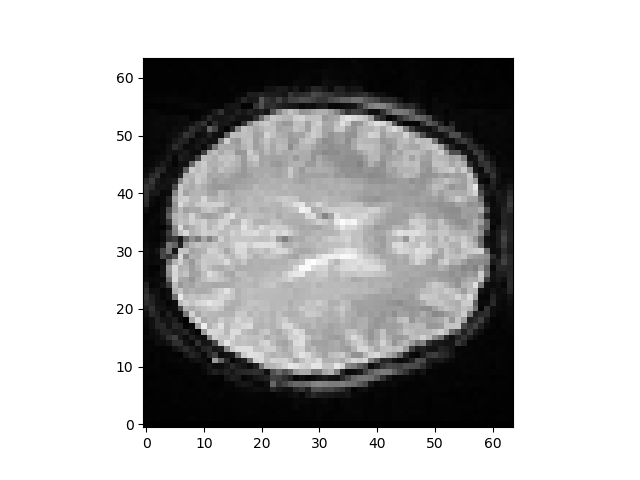

In [3]:
dim = volume.shape  # What is the size of the volume
dimsize = nii.header.get_zooms()  # Get voxel dimensions from the nifti header
tr = dimsize[3]
if tr > 100:  # If high then these values are likely in ms
    tr /= 1000
print(dim)
vol3d = nibabel.four_to_three(nii) # added, to print the brain image from dataset
for pp in vol3d:
    volDat = pp.get_fdata()
plt.imshow(volDat[:,:,15], cmap = "gray", origin = "lower")

In [4]:
mask, template = fmrisim.mask_brain(volume=volume, 
                                    mask_self=True,
                                    )

In [5]:
# Calculate the noise parameters from the data. Set it up to be matched.
noise_dict = {'voxel_size': [dimsize[0], dimsize[1], dimsize[2]], 'matched': 1}
noise_dict = fmrisim.calc_noise(volume=volume,
                                mask=mask,
                                template=template,
                                noise_dict=noise_dict,
                                )

/home/klips/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/klips/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [6]:
print('Noise parameters of the data were estimated as follows:')
print('SNR: ' + str(noise_dict['snr']))
print('SFNR: ' + str(noise_dict['sfnr']))
print('FWHM: ' + str(noise_dict['fwhm']))

Noise parameters of the data were estimated as follows:
SNR: 19.783347401210765
SFNR: 56.01952235589422
FWHM: 5.523156352119775


In [7]:
# Calculate the noise given the parameters
noise = fmrisim.generate_noise(dimensions=dim[0:3],
                               tr_duration=int(tr),
                               stimfunction_tr=[0] * dim[3], 
                               mask=mask,
                               template=template,
                               noise_dict=noise_dict,
                               )

/home/klips/anaconda3/envs/venv/lib/python3.7/site-packages/scipy/stats/stats.py:2279: RuntimeWarning: divide by zero encountered in true_divide
  np.expand_dims(sstd, axis=axis))
/home/klips/anaconda3/envs/venv/lib/python3.7/site-packages/scipy/stats/stats.py:2279: RuntimeWarning: invalid value encountered in true_divide
  np.expand_dims(sstd, axis=axis))


<IPython.core.display.Javascript object>


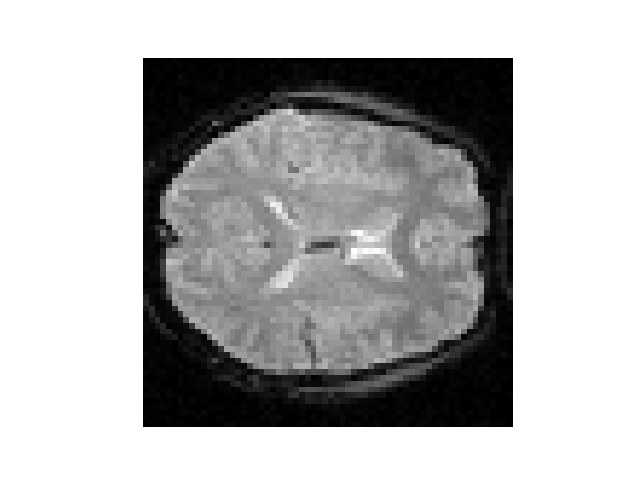

(-0.5, 63.5, 63.5, -0.5)

In [27]:
# Plot a slice through the noise brain
plt.figure()
plt.imshow(noise[:, :, int(dim[2] / 2), 0], cmap=plt.cm.gray)
plt.axis('off')

<IPython.core.display.Javascript object>


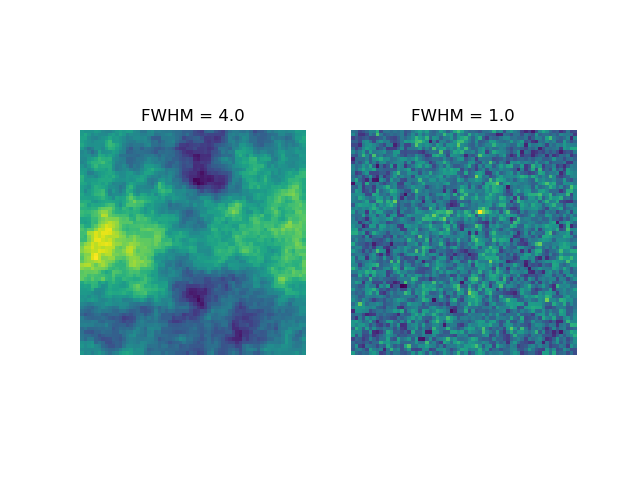

(-0.5, 63.5, 63.5, -0.5)

In [28]:
# Plot spatial noise
low_spatial = fmrisim._generate_noise_spatial(dim[0:3],
                                              fwhm=4.0,
                                              )

high_spatial = fmrisim._generate_noise_spatial(dim[0:3],
                                               fwhm=1.0,
                                               )
plt.figure()
plt.subplot(1,2,1)
plt.title('FWHM = 4.0')
plt.imshow(low_spatial[:, :, 12])
plt.axis('off')

plt.subplot(1,2,2)
plt.title('FWHM = 1.0')
plt.imshow(high_spatial[:, :, 12])
plt.axis('off')

In [10]:
# Create the different types of noise
total_time = 500
timepoints = list(range(0, total_time, int(tr)))

drift = fmrisim._generate_noise_temporal_drift(total_time,
                                               int(tr),
                                               )

mini_dim = np.array([2, 2, 2])
autoreg = fmrisim._generate_noise_temporal_autoregression(timepoints,
                                                          noise_dict,
                                                          mini_dim,
                                                          np.ones(mini_dim)
                                                          )
            
phys = fmrisim._generate_noise_temporal_phys(timepoints,
                                            )

stimfunc = np.zeros((int(total_time / tr), 1))
stimfunc[np.random.randint(0, int(total_time / tr), 50)] = 1
task = fmrisim._generate_noise_temporal_task(stimfunc,
                                            )

<IPython.core.display.Javascript object>


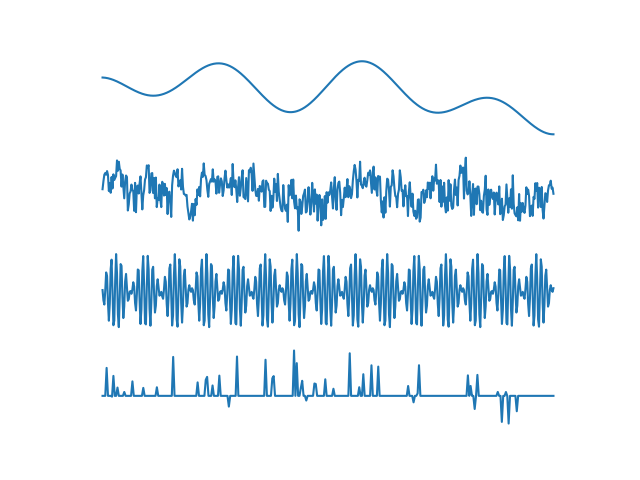

Text(0.5, 0, 'Task')

In [29]:
# Plot the different noise types
plt.figure()
plt.title('Noise types')

plt.subplot(4, 1, 1)
plt.plot(drift)
plt.axis('off')
plt.xlabel('Drift')

plt.subplot(4, 1, 2)
plt.plot(autoreg[0, 0, 0, :])
plt.axis('off')
plt.xlabel('Autoregression')

plt.subplot(4, 1, 3)
plt.plot(phys)
plt.axis('off')
plt.xlabel('Physiological')

plt.subplot(4, 1, 4)
plt.plot(task)
plt.axis('off')
plt.xlabel('Task')

<IPython.core.display.Javascript object>


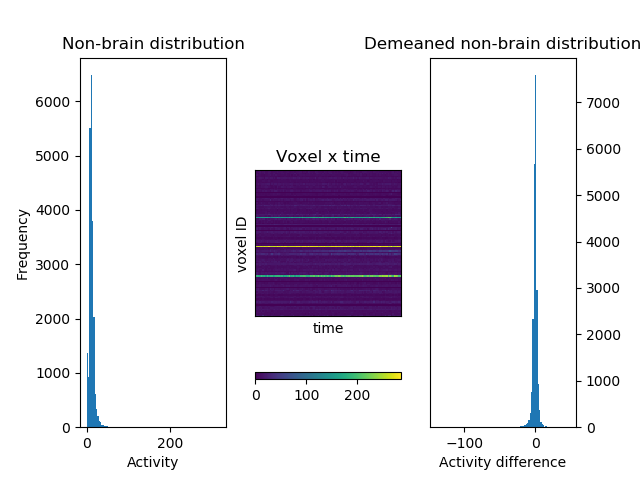

Text(0.5, 0, 'Activity difference')

In [30]:
# Dilate the mask so as to only take voxels far from the brain (performed in calc_noise)
mask_dilated = ndimage.morphology.binary_dilation(mask, iterations=10)

# Remove all non brain voxels
system_all = volume[mask_dilated == 0]  # Pull out all the non brain voxels in the first TR
system_baseline = volume - (template.reshape(dim[0], dim[1], dim[2], 1) * noise_dict['max_activity'])  # Subtract the baseline before masking
system_baseline = system_baseline[mask_dilated == 0]

# Plot the distribution of voxels
plt.figure()
plt.subplot(1, 3, 1)
plt.hist(system_all[:,0].flatten(),100)
plt.title('Non-brain distribution')
plt.xlabel('Activity')
plt.ylabel('Frequency')

# Identify a subset of voxels to plot
idxs = list(range(system_all.shape[0]))
np.random.shuffle(idxs)

temporal = system_all[idxs[:100], :100]
plt.subplot(1, 3, 2)
plt.imshow(temporal)
plt.xticks([], [])
plt.yticks([], [])
plt.ylabel('voxel ID')
plt.xlabel('time')
plt.title('Voxel x time')
plt.colorbar(orientation = 'horizontal')

# Plot the difference
ax=plt.subplot(1, 3, 3)
plt.hist(system_baseline[:,0].flatten(),100)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
plt.title('Demeaned non-brain distribution')
plt.xlabel('Activity difference')

In [13]:
# Compute the noise parameters for the simulated noise
noise_dict_sim = {'voxel_size': [dimsize[0], dimsize[1], dimsize[2]], 'matched': 1}
noise_dict_sim = fmrisim.calc_noise(volume=noise,
                                    mask=mask,
                                    template=template,
                                    noise_dict=noise_dict_sim,
                                    )

In [14]:
print('Compare noise parameters for the real and simulated noise:')
print('SNR: %0.2f vs %0.2f' % (noise_dict['snr'], noise_dict_sim['snr']))
print('SFNR: %0.2f vs %0.2f' % (noise_dict['sfnr'], noise_dict_sim['sfnr']))
print('FWHM: %0.2f vs %0.2f' % (noise_dict['fwhm'], noise_dict_sim['fwhm']))
print('AR: %0.2f vs %0.2f' % (noise_dict['auto_reg_rho'][0], noise_dict_sim['auto_reg_rho'][0]))

Compare noise parameters for the real and simulated noise:
SNR: 19.78 vs 19.35
SFNR: 56.02 vs 58.18
FWHM: 5.52 vs 5.59
AR: 0.92 vs 0.89


In [15]:
# Create the region of activity where signal will appear
coordinates = np.array([[21, 21, 21]])  # Where in the brain is the signal
feature_size = 3  # How big, in voxels, is the size of the ROI
signal_volume = fmrisim.generate_signal(dimensions=dim[0:3],
                                        feature_type=['cube'],
                                        feature_coordinates=coordinates,
                                        feature_size=[feature_size],
                                        signal_magnitude=[1],
                                        )

<IPython.core.display.Javascript object>


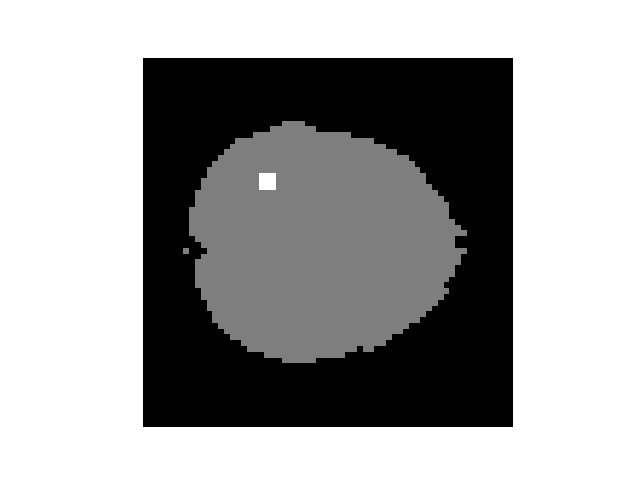

(-0.5, 63.5, 63.5, -0.5)

In [31]:
plt.figure()
plt.imshow(signal_volume[:, :, 21], cmap=plt.cm.gray) # set slice number here to observe the right one
plt.imshow(mask[:, :, 21], cmap=plt.cm.gray, alpha=.5)
plt.axis('off')

In [17]:
# Create a pattern for each voxel in our signal ROI
voxels = feature_size ** 3

# Pull the conical voxel activity from a uniform distribution
pattern_A = np.random.rand(voxels).reshape((voxels, 1))  
pattern_B = np.random.rand(voxels).reshape((voxels, 1))

<IPython.core.display.Javascript object>


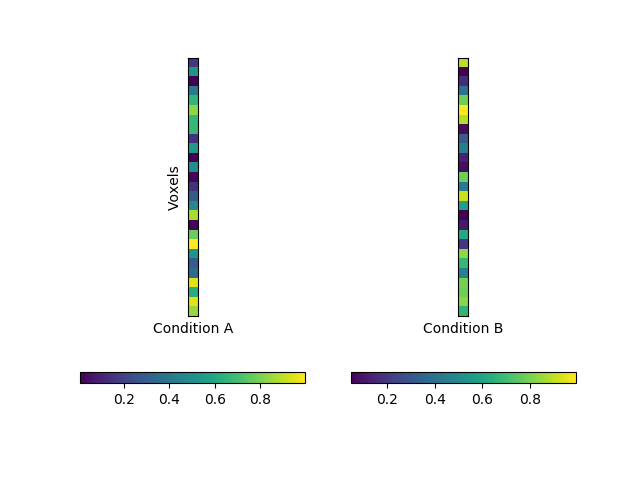

In [32]:
# Plot pattern of activity for each condition
plt.figure()
plt.subplot(1,2,1)
plt.imshow(pattern_A)
plt.ylabel('Voxels')
plt.tick_params(which='both', left=False, labelleft=False, bottom=False, labelbottom=False)
plt.xlabel('Condition A')
plt.colorbar(orientation = 'horizontal')

plt.subplot(1,2,2)
plt.imshow(pattern_B)
plt.tick_params(which='both', left=False, labelleft=False, bottom=False, labelbottom=False)
plt.xlabel('Condition B')
plt.colorbar(orientation = 'horizontal')

In [19]:
# Set up stimulus event time course parameters
event_duration = 2  # How long is each event
isi = 7  # What is the time between each event
burn_in = 1  # How long before the first event

total_time = int(dim[3] * tr) + burn_in  # How long is the total event time course
events = int((total_time - ((event_duration + isi) * 2))  / ((event_duration + isi) * 2)) * 2  # How many events are there?
onsets_all = np.linspace(burn_in, events * (event_duration + isi), events)  # Space the events out
np.random.shuffle(onsets_all)  # Shuffle their order
onsets_A = onsets_all[:int(events / 2)]  # Assign the first half of shuffled events to condition A
onsets_B = onsets_all[int(events / 2):]  # Assign the second half of shuffled events to condition B
temporal_res = 10.0 # How many timepoints per second of the stim function are to be generated?

In [20]:
# Create a time course of events 
stimfunc_A = fmrisim.generate_stimfunction(onsets=onsets_A,
                                           event_durations=[event_duration],
                                           total_time=total_time,
                                           temporal_resolution=temporal_res,
                                           )

stimfunc_B = fmrisim.generate_stimfunction(onsets=onsets_B,
                                           event_durations=[event_duration],
                                           total_time=total_time,
                                           temporal_resolution=temporal_res,
                                           )

In [21]:
fmrisim.export_epoch_file(stimfunction=[np.hstack((stimfunc_A, stimfunc_B))],
                          filename=home + '/epoch_file.npy',
                          tr_duration=tr,
                          temporal_resolution=temporal_res,
                          )

fmrisim.export_3_column(stimfunction=stimfunc_A,
                        filename=home + '/Condition_A.txt',
                        temporal_resolution=temporal_res,
                        )

fmrisim.export_3_column(stimfunction=stimfunc_B,
                        filename=home + '/Condition_B.txt',
                        temporal_resolution=temporal_res,
                        )

In [22]:
# Multiply each pattern by each voxel time course
weights_A = np.matlib.repmat(stimfunc_A, 1, voxels).transpose() * pattern_A
weights_B = np.matlib.repmat(stimfunc_B, 1, voxels).transpose() * pattern_B

# Sum these time courses together
stimfunc_weighted = weights_A + weights_B
stimfunc_weighted = stimfunc_weighted.transpose()

<IPython.core.display.Javascript object>


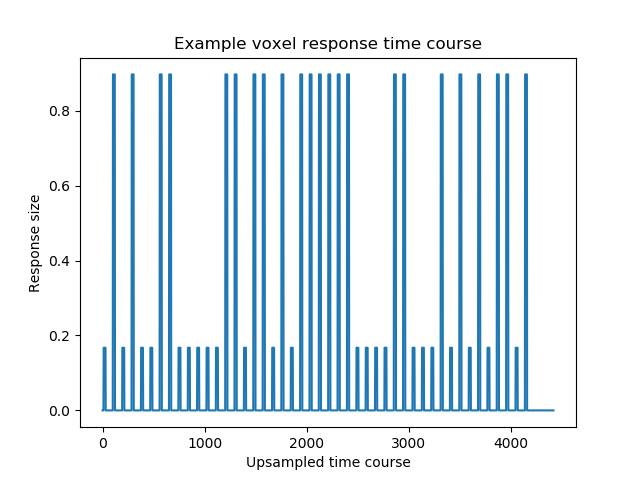

Text(0, 0.5, 'Response size')

In [33]:
plt.figure()
plt.plot(stimfunc_weighted[:, 0])
plt.title('Example voxel response time course')
plt.xlabel('Upsampled time course')
plt.ylabel('Response size')

In [24]:
signal_func = fmrisim.convolve_hrf(stimfunction=stimfunc_weighted,
                                   tr_duration=tr,
                                   temporal_resolution=temporal_res,
                                   scale_function=1,
                                   )

<IPython.core.display.Javascript object>


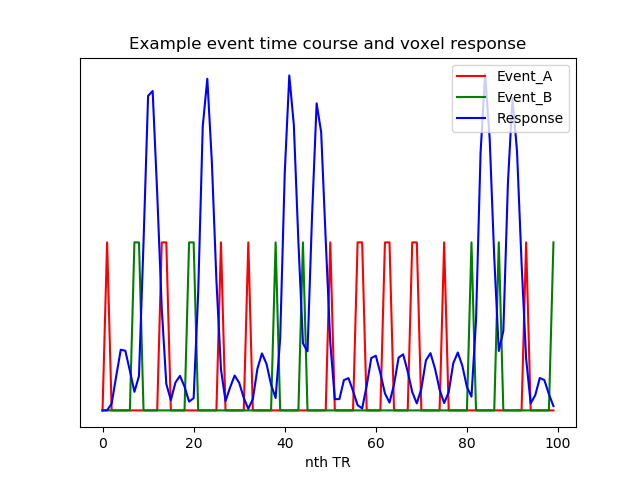

Text(0.5, 0, 'nth TR')

In [34]:
# Prepare the data to be plotted
response = signal_func[0:100,0] * 2
downsample_A = stimfunc_A[0:int(100*temporal_res * tr):int(temporal_res * tr), 0]
downsample_B = stimfunc_B[0:int(100*temporal_res * tr):int(temporal_res * tr), 0]

# Display signal
plt.figure()
plt.title('Example event time course and voxel response')
Event_A = plt.plot(downsample_A, 'r', label='Event_A')
Event_B = plt.plot(downsample_B, 'g', label='Event_B')
Response = plt.plot(response, 'b', label='Response')
plt.legend(loc=1)
plt.yticks([],'')
plt.xlabel('nth TR')

In [36]:
# Specify the parameters for signal
signal_method = 'CNR_Amp/Noise-SD'
signal_magnitude = [0.5]

# Where in the brain are there stimulus evoked voxels
signal_idxs = np.where(signal_volume == 1)

# Pull out the voxels corresponding to the noise volume
noise_func = noise[signal_idxs[0], signal_idxs[1], signal_idxs[2], :]

In [37]:
# Compute the signal appropriate scaled
signal_func_scaled = fmrisim.compute_signal_change(signal_func,
                                                  noise_func,
                                                  noise_dict,
                                                  magnitude=signal_magnitude,
                                                  method=signal_method,
                                                  )

In [38]:
# Specify the parameters for signal
signal_method = 'CNR_Amp/Noise-SD'
signal_magnitude = [0.5]

# Where in the brain are there stimulus evoked voxels
signal_idxs = np.where(signal_volume == 1)

# Pull out the voxels corresponding to the noise volume
noise_func = noise[signal_idxs[0], signal_idxs[1], signal_idxs[2], :]

In [39]:
signal = fmrisim.apply_signal(signal_func_scaled,
                              signal_volume,
                              )

In [40]:
brain = signal + noise

In [41]:
hrf_lag = 4  # Assumed time from stimulus onset to HRF peak

# Get the lower and upper bounds of the ROI
lb = (coordinates - ((feature_size - 1) / 2)).astype('int')[0]
ub = (coordinates + ((feature_size - 1) / 2) + 1).astype('int')[0]

# Pull out voxels in the ROI for the specified timepoints
trials_A = brain[lb[0]:ub[0], lb[1]:ub[1], lb[2]:ub[2], ((onsets_A + hrf_lag) / tr).astype('int')]
trials_B = brain[lb[0]:ub[0], lb[1]:ub[1], lb[2]:ub[2], ((onsets_B + hrf_lag) / tr).astype('int')]

# Reshape data for easy handling
trials_A = trials_A.reshape((voxels, trials_A.shape[3]))
trials_B = trials_B.reshape((voxels, trials_B.shape[3]))

<IPython.core.display.Javascript object>


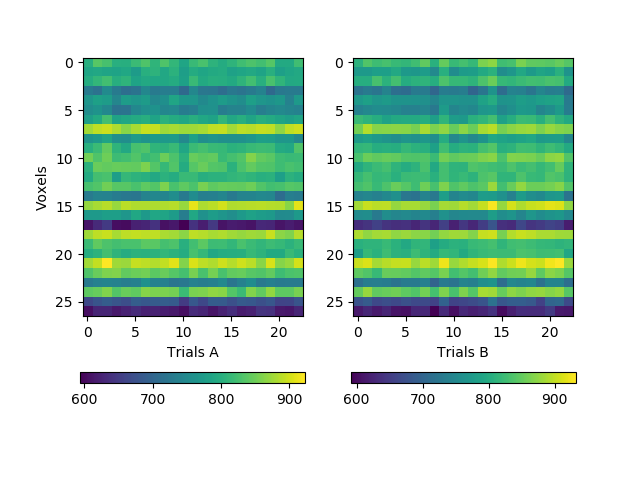

Text(0.5, 0, 'Trials B')

In [42]:
# Plot the pattern of activity for our signal voxels at each timepoint
plt.figure()
plt.subplot(1,2,1)
plt.imshow(trials_A)
plt.colorbar(orientation = 'horizontal')
plt.ylabel('Voxels')
plt.xlabel('Trials A')
plt.subplot(1,2,2)
plt.imshow(trials_B)
plt.colorbar(orientation = 'horizontal')
plt.xlabel('Trials B')

<IPython.core.display.Javascript object>


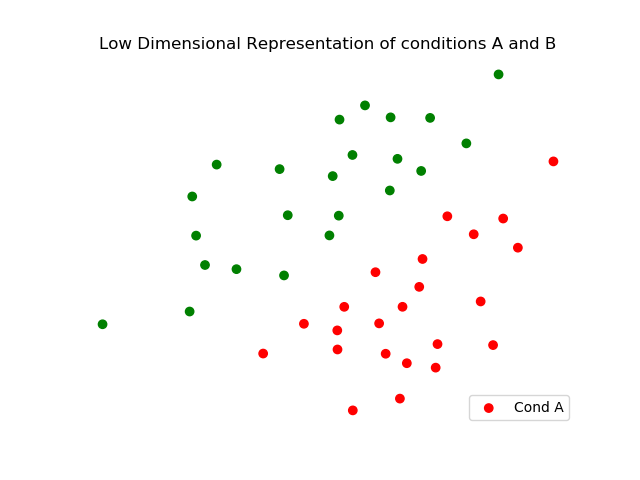

In [43]:
# Calculate the distance matrix between trial types
distance_matrix = sp_distance.squareform(sp_distance.pdist(np.vstack([trials_A.transpose(), trials_B.transpose()])))

mds = manifold.MDS(n_components=2, dissimilarity='precomputed')  # Fit the mds object
coords = mds.fit(distance_matrix).embedding_  # Find the mds coordinates

# Plot the data
plt.figure()
plt.scatter(coords[:, 0], coords[:, 1], c=['red'] * trials_A.shape[1] + ['green'] * trials_B.shape[1])
plt.axis('off')
plt.title('Low Dimensional Representation of conditions A and B')
plt.legend(['Cond A', 'Cond B'], loc = 'lower right')

In [44]:
mean_difference = (np.mean(trials_A,0) - np.mean(trials_B,0))
ttest = stats.ttest_1samp(mean_difference, 0)

print('Mean difference between condition A and B: %0.2f\np value: %0.3f' % (mean_difference.mean(), ttest.pvalue))

Mean difference between condition A and B: -5.57
p value: 0.062


In [45]:
# Get the inputs to the SVM
input_mat = np.vstack([trials_A.transpose(), trials_B.transpose()])
input_labels = trials_A.shape[1] * [1] + trials_B.shape[1] * [0]

# Set up the classifier
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    input_mat, input_labels, test_size=0.2, random_state=0)

clf = sklearn.svm.SVC(kernel='linear', C=1).fit(X_train, y_train)

score = clf.score(X_test, y_test)
print('Classification accuracy between condition A and B: %0.3f' % score)

Classification accuracy between condition A and B: 1.000
